# MAHLERAN+A: A reimplementation and extension of MAHLERAN in Julia for joint studies in hydraulic and aeolian transport

###### A.K. Naylor, after Wainwright & Parsons

## Why Julia?

I had numerous small issues in compiling regular MAHLERAN, largely related to reading of variables from XML but also related to incompatibility between different releases of GCC, requiring breaking up compilation, running parts on one computer and others on another. The combined recognition of this approach’s difficulty and my learning of Julia, a high-level language comparable in speed to C (or in some cases FORTRAN; it is supplanting both in some actuarial and physical applications) while remaining dynamically-typed (see <a href="https://ucidatascienceinitiative.github.io/IntroToJulia/Html/WhyJulia">here</a>), not to mention easier notebook work than invoking Fortran magic in each cell. I was able to teach myself and rebuild the raindrop detachment model (I also built part of the unconcentrated flow, but my health intervened and raindrop detachment was it). The syntax is not particularly “Julian” (particularly for loops) for the sake of wider comprehensibility. When I tried to return in the spring I managed to complete the aeolian model, so both raindrop and aeolian are working in concert.

With Julia it is recommended to add packages (e.g. to get jupyter notebooks we’d use `using Pkg, Pkg.add("IJulia")` in the REPL followed by `notebook()`. Note that Julia is expanded by a number of packages, loaded here in the first cell. To initially download, and later update, these packages an internet connection is required. However, once these are added to Julia you can simply use them and do not have to update (i.e. you can  just use the block with `using X / using Y` &c).

Arrays, unusually, start at 1. White space is here for clarity but it is not required. Julia is case-sensitive.

A caution on in-notebook contour plots:

1. The contour plot needs a different name than the array displayed.
2. Contours are the only thing in Julia that’s slow
3. They are buggy and may require a kernel restart

In [1]:
## Setting up packages
# using Pkg; Pkg.add("GR"); using GR
using Pkg; Pkg.add("DelimitedFiles")
# using Pkg; Pkg.add("OrdinaryDiffEq")
# using OrdinaryDiffEq
using Pkg; Pkg.add("CSV")

using Pkg; Pkg.add("LightGraphs")
Pkg.add("BenchmarkTools")
import Pkg; Pkg.add("DataFrames")
# using Pkg; Pkg.add("Gtk")
# using Gtk
using Pkg; Pkg.add("Plots")
# using Pkg; Pkg.add("PyPlot")
# using PyPlot
using Pkg; Pkg.add("Images")
using Pkg; Pkg.add("Colors")
using Pkg; Pkg.add("Random")
using Pkg; Pkg.add("Distributions")
using Pkg; Pkg.add("ColorSchemes")
using Pkg; Pkg.add("ImageTransformations")
using Pkg; Pkg.add("Gtk")
using Pkg; Pkg.add("ImageView")
using Pkg; Pkg.add("IterTools")

using DelimitedFiles
using CSV
using LightGraphs
using BenchmarkTools
using DataFrames
using Plots
using Colors
using Images
using Random
using Distributions
using ColorSchemes
using ImageTransformations
using Gtk
using ImageView
using IterTools

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`


First we start out with some essential parameterizations. The first is for landscape parameters, often read from delimited files, and the second related more to particle and particle transport parameters.

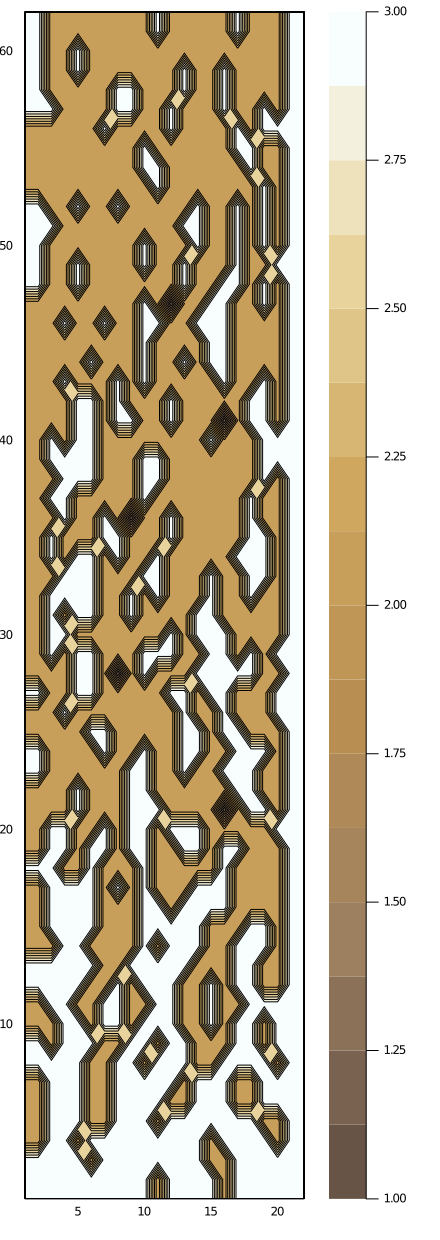

In [31]:
###Landscape parameters
xmin = readdlm("testdem_params.asc")[3,2] + 1
ymin = readdlm("testdem_params.asc")[4,2] + 1
dx = readdlm("testdem_params.asc")[5,2]
nodata = readdlm("testdem_params.asc")[6,2]
# dx_m = copy(dx) #dx in meters
# dx_mm = dx*1000

z = readdlm("testdem.asc")

nc1 = size(z,1)
nc = nc1-1
nc2 = nc1+1

nr1 = size(z,2)
nr = nr1-1
nr2 = nr1 + 1
# print(size(z))

###Soil h per cell in m, can also be done per surface type j, mm, just using a dummy value here
###could also be read from such as
###soil_height = readdlm("soil_height.asc") 
h = fill(0.0150,(nc1,nr1))
z_soil = h + z
imtest = h


###Aspects:
#0 = No slope
#1 = “W”
#2 = Downslope
#3 = “East”
#4 = Upslope


aspect = fill(0, (nc1,nr1))

for i in 2:nc, j in 2:nr
    if z[i,j] - z[i+1,j] < 0
        aspect[i,j] = 1
    elseif z[i,j] - z[i,j+1] < 0
        aspect[i,j] = 2
    elseif z[i,j] - z[i-1,j] < 0
        aspect[i,j] = 3
    elseif z[i,j] - z[i, j-1] < 0
        aspect[i,j] = 4
    end
end
for i in 2:nc, j in 2:nr
    if aspect[i,j] == 0
        aspect[i,j] = 2
    end
end

# print(aspect)

zmin = z .* aspect
# #println(zmin)
slope = [zmin[i+1,j] .- zmin[i,j] for i in 1:nc, j in 1:nr1]
temp = fill(0, (1,nr1))

# #Compensating for edge effects by setting them equal to interior
slope[1,:] .= slope[2,:]
slope = [slope;temp]
slope[nc1,:] .= slope[nc,:]
slope[:,1] .= slope[:,2]
slope[:,nr1] .= slope[:,nr]

aspect[1,:] .= aspect[2,:]
aspect[nc1,:] .= aspect[nc,:]
aspect[:,1] .= aspect[:,2]
aspect[:,nr1] .= aspect[:,nr]

# a1 = contour(aspect, fill=true, size = (220, 620),seriescolor=cgrad(ColorSchemes.coffee.colors))

###Hydrological maps—soil moisture Θ, saturated soil moisture Θ_sat, matric suction ψ
theta = readdlm("testsm.csv",',')
thetasat = fill(0.04,(nc1,nr1))
psi = fill(5,(nc1,nr1))


###Reading soil size distributions—for testing purposes just using uniform for Udden-Wentworth 1

### Use however many phi are in the source material
# phi = [1,2,3,4]
phi = 1

phi1_map = readdlm("phi1uniform.asc")
# phi2_map = readdlm("phi2uniform.asc")
# phi3_map = readdlm("phi3uniform.asc")
# phi4_map = readdlm("phi4uniform.asc")


# Theta-switch: a switch depending on whether we simply assumine rainwater infiltrates after 
# a day or whether it’s based on infiltration

h = fill(0.015,(nc1,nr1))
soil_height = h
imtest = soil_height
z_soil = soil_height+z
aspect_check = contour(aspect, fill=true, size = (220*2, 620*2),  seriescolor=cgrad(ColorSchemes.coffee.colors))

In [32]:
###Splash/unconcentrated flow preallocation
rainmap = fill(0.,(nc1,nr1))
    
d = fill(0.,(nc1,nr1))
c = fill(0., (nc1,nr1))
excess = fill(0., (nc1,nr1))
f = fill(0., (nc1,nr1))
    
f1 = fill(0., (nc1,nr1))

v = fill(0., (nc1,nr1))
    
q = fill(0., (nc1,nr1))

cum_inf = fill(0.,(nc1,nr1))

water_in = fill(0., (nc1,nr1))

drain = fill(0., (nc1,nr1))



dsum = 0

tracker = 0

detach_soil = fill(0.,(phi,nc1,nr1))
depos_soil = fill(0.,(phi,nc1,nr1))
aeol_remove = fill(0.,(phi,nc1,nr1))
aeol_depos = fill(0.,(phi,nc1,nr1))

#Eventually have a sed_propn map dep. on size
sed_propn = fill(1, (size(phi,1),nc1,nr1))

grav_propn = fill(0., (size(phi,1),nc1,nr1))


####Other, particular and directional parameters


###phi_map—not using here since only using U-W 1
#phi_map = cat(phi1_map,phi2_map,phi3_map,phi4_map,dims=3)

### Particle parameters
### Particle radii in m
nt_top_up = 1
#phi = [1,2,3,4]
###Just having 1 for simplicity—can be set up manually depending on soil maps


radius = [0.03125, 0.071825, 0.1875, 0.6250]
diameter = 2. .* radius
diameter_meters = diameter/1000
rho = 2650 ##in kgm^-3

sigma = (0.001 * rho - 0.001)/0.001

####Phi detachment parameters—hydraulic
sma = [1.373, 34.52, 17.459, 6.572]
smb = [0.069, 0.091, 0.083, 0.081]
spd = [14.49275, 10.98901, 12.04819, 12.34568]
spq = [2.72, 1.61, 0.92, 0.85]

spa = [4.38E-05, 8.31E-04, 5.25E-04, 8.31E-04]
spb = [1.24, 1.08, 0.79, 0.75]
spc = [0.23, 0.21, 0.11, 1.06]
spd = [0.23, 0.21, 0.11, 1.06]


###Phi detachment parameters—aeolian

###In FORTRAN the following would be under 
###call read_params_aeolian


###Controls angle of repose
slump_ratio = 2

###Incoming sediment, here 0 for demonstrative purposes
incoming = [0.,0.,0.,0.]

####Thresholds for aeolian entrainment—also repeated below
ustar_thresh = [0.4374, 0.5865, 0.6765, 1.675]

depth_A = [0.3284,0.5564, 0.5256, 1.030]
depth_B = [-0.5579, -0.4384, -0.438]
depth_C = [-0.4135, -0.707, -1.453]


for p in 1:4
    if p == 1 || p == 2
            d_det_A = [0.0258, 0.1455]
            d_det_B = [0.5846, 0.2557]
            d_det_C = [0.0409, 0.0069]
            
#             d_Calc = d_det_A
            ## and the rest of the model goes here
            
        elseif p == 3
            d_det_M = 0.1144
            d_det_D = 0.3153
            
            ## and the rest of the model goes here
            
        else p == 4
            d_det_Const = 1.604
        
            ## and the rest of the model goes here
        
    end
    
end

###Directions in the event of a full slump model
Moore = fill(0.,(1,8))

1×8 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

Not at the moment; as such a the constant `ksat` value is simply used across the entire landscape. The same goes for maps indicating changes in the Darcy-Weisbach friction factor *ff*, which is here simply calculated in-model as *ff* $ = 14-0.08h$ where $h$ is flow depth. Calibration is also left out given that this is a simple test slope. Also these are more important for concentrated flow, which I’m not dealing with here.

In [33]:
viscosity = 0.00000103

## Not used since we aren’t taking suspension into account, but dstar_const used for h. susp. criteria
dstar_const = (((sigma - 1.) * 9.81)/ (viscosity ^ 2)) ^ (1 / 3)

ksat = 0.6


lambda = 0.16

drain_par = 0.05

gfconst = 9.81 * 8.

function dwff(h)
    ff = 14 - (0.8 * h)
end

dwff (generic function with 1 method)

Now we add some splash parameterizations

In [34]:
### Splash parameterizations

if dx ≥ 300.0
    nsteps = trunc(Int, max(((5.0/ dx) + 0.5), 2))
else
    nsteps = 1
end
    
max_diffuse = trunc(Int, max(((10.0/ dx) + 0.5), 2))

max_diffuse = trunc(Int, max(((100.0/ dx) + 0.5), 2))

max_hsusp = trunc(Int, max(((500.0/ dx) + 0.5), 2))
    
## Constant term used to define pickup probability in concentrated flow. 
## Used in flow_detachment subroutine.
p_par = -(2/π)

z_init = copy(z)
    
##Converting to mm
area = 0.000001 * z_init

print(nsteps)

1

#### Bringing in the rain timeseries

Rain timeseries aren’t consistent across existing MAHLERAN experiments (and seem to often be processed out-of-model). However, recent experiments tend to be of the format year-Julian day-hour-minute, with the bottom line having the nodata value of `-9999`. Loading this table, we remove the final row and use the year column to add each year’s Julian days; we then make a new column where dates are expressed as Julian days from the beginning of the year for rain events.

After we comement this out and write our final timeseries array in the code cell after next in order to save us the trouble of redoing this each time. This is also the only part of the model which I have a hard time imagining done in Fortran since it works through dataframes, so this might be best left to Julia/Pandas/R.

In [35]:
datearray = readdlm("Rain2008_year.dat")
temprow = size(datearray,1)
# stormlength = readdlm("Rain2008_year.dat")

year_leap = 366
year = 365

yr1 = datearray[datearray[:,1] .== datearray[1,1], :]
yr1test = yr1[:,2] 
yr1fin = [yr1test (yr1[:,5]/1000)] ###Converting from mm/hour to m/hour

yr2 = datearray[datearray[:,1] .== datearray[1,1]+1, :]
yr2test = yr2[:,2] .+ year_leap
yr2fin = [yr2test (yr2[:,5]/1000)]

yr3 = datearray[datearray[:,1] .== datearray[1,1]+2, :]
yr3test = yr3[:,2] .+ year_leap .+ year
yr3fin = [yr3test (yr3[:,5]/1000)]

jularray = [yr1fin; yr2fin; yr3fin]
jul_frame = convert(DataFrame,jularray)
gdf = DataFrames.groupby(jul_frame, :x1)
hydro_event_frame = combine(gdf, :x2 => median)
hydro_eventarray = convert(Matrix,hydro_event_frame)

hydro_length = size(hydro_eventarray,1)

#if no storm length available then simply have rainfall 
# intersity as 1—see main loop far below

# for i in 1:hydro_length
#     hydro_eventarray[i,2] = hydro_eventarray[i,2] * stormlength
# end


# hydro_duration = trunc(Int64,(size(hydro_eventarray,1)/size(jularray,1)*24))

119

Of course the above is only for hydrological events—in the same timespan we also have to take into aeolian events in between. Thus we insert rainfall values into a full timeline below, with the rainfall numbers corresponding to The additional two columns for wind strength and direction (expressed in anywhere from 1-4 to 1-32 compass directions), which aren’t recorded here and are just manually done below. These are both median wind strength for day per day integer average given variability (likely for `wd`?).

Note that while the first *entry* here is at 0.0, since Julia arrays start at 1 all loops are still at from `1:x` or from `2:x` or `1:x-1` (when `i-1` or `i+1` needs to be called or edge effects—this is why we define `nc` and `nc2` as well).

Since this is over a long period of time it does not `stormlength` would be incorporated into rainfall intensity (i.e. storm length, if avalailable, would be a percentage of overall intensity). In addition, since infiltration is so fast and rainfall volume so low we can get away with just just making sure wind speed and direction are set to zero.


Of course, this can also be done over short timescales, e.g. a timeseries a few days w/a resolution of minutes, for example (in which we’d watch `theta_switch` to be set to take into account infiltration).

In [36]:
# days_max = maximum(hydro_eventarray[:,1])
# days_incr = [0:1:days_max;]
# days_maxint = trunc(Int64,days_max)
# days_zeros = fill(0.,(days_maxint+1,3))
# days_array = hcat(days_incr, days_zeros)

# for i in 2:hydro_length
#     insert = trunc(Int64,hydro_eventarray[i,1] - hydro_eventarray[i-1,1])
# #     insert_int = trunc(Int64,insert)
#     days_array[i+insert,2] =  hydro_eventarray[i-1,2]
# end


# days_array[1,2] = hydro_eventarray[1,2]
# days_array[days_maxint+1,2] = hydro_eventarray[hydro_length,2]

# days_length = size(days_array,1)


# for i in 1:days_length
#     if days_array[i,2] > 0
#         days_array[i,3] = 0
#     end
# end

# writedlm("days_array.csv",days_array)

days_array = readdlm("days_array.csv")

1096×4 Array{Float64,2}:
    0.0  0.00027   0.0  0.0
    1.0  0.0       0.0  0.0
    2.0  0.0       0.0  0.0
    3.0  0.0       0.0  0.0
    4.0  0.00011   0.0  0.0
    5.0  0.0       0.0  0.0
    6.0  0.00011   0.0  0.0
    7.0  0.0       0.0  0.0
    8.0  0.0       0.0  0.0
    9.0  0.00011   0.0  0.0
   10.0  0.00011   0.0  0.0
   11.0  0.000165  0.0  0.0
   12.0  0.00011   0.0  0.0
    ⋮                   
 1084.0  0.0       0.0  0.0
 1085.0  0.0       0.0  0.0
 1086.0  0.0       0.0  0.0
 1087.0  0.0       0.0  0.0
 1088.0  0.0       0.0  0.0
 1089.0  0.0       0.0  0.0
 1090.0  0.0       0.0  0.0
 1091.0  0.0       0.0  0.0
 1092.0  0.0       0.0  0.0
 1093.0  0.0       0.0  0.0
 1094.0  0.0       0.0  0.0
 1095.0  0.00028   0.0  0.0

Given the quick infiltration time we assume that soil is dry enough for aeolian transport the next day, though this data could also be read from the raindrop wetting/splash/unconcentrated flow below.

Here we define a function `land_update`—this updates aspect and slope after each model run

In [37]:
function land_update!(nc,nr,nc1,nr1,z,aspect,slope)
    
    
    for i in 2:nc, j in 2:nr
        if z[i,j] - z[i+1,j] < 0
            aspect[i,j] = 1
        elseif z[i,j] - z[i,j+1] < 0
            aspect[i,j] = 2
        elseif z[i,j] - z[i-1,j] < 0
            aspect[i,j] = 3
        elseif z[i,j] - z[i, j-1] < 0
            aspect[i,j] = 4
        end
    end

    # print(aspect)

    zmin = z .* aspect
    # #println(zmin)
    slope = [zmin[i+1,j] .- zmin[i,j] for i in 1:nc, j in 1:nr1]
    temp = fill(0, (1,nr1))

    # #Compensating for edge effects by setting them equal to interior
    slope[1,:] .= slope[2,:]
    slope = [slope;temp]
    slope[nc1,:] .= slope[nc,:]
    slope[:,1] .= slope[:,2]
    slope[:,nr1] .= slope[:,nr]

    aspect[1,:] .= aspect[2,:]
    aspect[nc1,:] .= aspect[nc,:]
    aspect[:,1] .= aspect[:,2]
    aspect[:,nr1] .= aspect[:,nr]
    
    
    return z
    return aspect
    return slope

end

land_update! (generic function with 1 method)

Here’s our big loop for hydraulic processes. If rain > 0, then 

Here rainfall is set to a constant—if we want random rainfall per `i,j` we can simply use the commented-out code. Note that this is a “dumb” example where I’ve just entered it in rain.

It consists of both the infiltration and rainsplash $\rightarrow$ sediment redistribution models from MAHLERAN 1.2.1.

Now we begin with our initializations for the rain event and its effects on flow and soil moisture, as well as a couple for aeolian transport `detach_soil = fill(0.,(phi,nc1,nr1)); depos_soil = fill(0.,(phi,nc1,nr1))`. Additionally, note that we set rainfall intensity `rval`, and `t` here manually, and particle size classes `phi` here manually rather than read from arrays. This model still runs when there is no rain to take drainage into account. Note that erosion and deposition happens *very* slowly so unrealistic sequences of rainfall are used. The hydraulic model continues to run when `rval = 0` to account for drainage.

`s` is used here since the large iteration, covering both hydraulic and aeolian transport, uses `t`, and the time scale in the actual MAHLERAN model involves short time scales, even if we assume each event is only one hour.


In [38]:
detach_soil = fill(0.,(phi,nc1,nr1))
depos_soil = fill(0.,(phi,nc1,nr1))
ncelldistr = 1
rval = 0.0027


#Eventually have a sed_propn map dep. on size
sed_propn = fill(1, (size(phi,1),nc1,nr1))

grav_propn = fill(phi, (size(phi,1),nc1,nr1))


####INITIALIZING FRICTION FRACTION
ff = fill(0.,(nc1,nr1))
for i in 1:nc1
    for j in 1:nr1
         ff[i,j] = 14. - (0.8 * h[i,j])
    end
end



final_infilt = lambda  * (1 - exp(-rval) / lambda)

f = fill(final_infilt,(nc1,nr1))


#DONE IN A “DUMB” WAY HERE, TO BE READ IN THE FUTURE



for s in 1:1
Random.seed!(s)
    for i in 1:nc1
        for j in 1:nr1
        rainmap[i,j] = rand((0, 1)) * rval
        end
    end


    
        
    for i in 1:nc1
        for j in 1:nr1
            water_in[i,j] = rainmap[i,j] + d[i,j]
            if f[i,j] < water_in[i,j]
                if f[i,j] > rainmap[i,j]
                    f1[i,j] = f[i,j] - rainmap[i,j]
        
                 d[i,j] = d[i,j] - f1[i,j]
                    
                # USED FOR CONCENTRATED FLOW        
#                  v[i,j] = √(abs(ff[i,j] * gfconst .* d[i,j] .* slope[i,j]))
                
#                  q[i,j] = d[i,j] * v[i,j]
                
                 cum_inf[i,j] = cum_inf[i,j] - f[i,j]
                
                if cum_inf[i,j] >= drain[i,j]
                    cum_inf[i,j] = cum_inf[i,j] - drain[i,j]
#                     print(cum_inf)
                else
                    drain[i,j] = cum_inf[i,j]
                    cum_inf[i,j] = 0.
                end
            elseif f[i,j] == ksat + psi[i,j]
                if f[i,j] ≥ rainmap[i,j]
#                 print("lookaroundyou")
                    excess[i,j] = rainmap[i,j] * f[i,j]
                    cum_inf[i,j] = cum_inf[i,j] + f[i,j]
                    if cum_inf[i,j] ≥ drain[i,j]
#                         print("lookaroundyou")
                        cum_inf[i,j] = cum_inf[i,j] - drain[i,j]
                    else
                        drain[i,j] = cum_inf[i,j]
                        cum_inf[i,j] = 0.
                    end
                end
            end
            cum_inf[i, j] = cum_inf[i, j] + water_in[i,j]
            if cum_inf[i,j] ≥ drain[i,j]
                cum_inf[i,j] = cum_inf[i,j] - drain[i,j]
                else 
                    drain[i,j] = cum_inf[i,j]
                    cum_inf[i,j] = 0.
                end
            if cum_inf[i,j] > h[i,j]
                excess[i,j] = excess[i,j] + cum_inf[i,j] - h[i,j]
            end
#      end
#      end
#                 end

     theta = cum_inf ./ soil_height .* thetasat
     d = water_in + rainmap .* thetasat - theta
        end
    end
    end


### NOW WE GET TO SOIL DETACHMENT AND ROUNTING
ke = fill(0.,(nc1,nr1))
for i in 1:nc1
    for j in 1:nr1
        if rainmap[i,j] > 0
            ke[i,j] = abs(11.9 + 8.73 * log10(rainmap[i,j] * 3.63))
        end
    end
end


for p in 1:phi
    spa = abs(spa[phi])
#     print(a)
    spb = abs(spb[phi])
#     print(b)
    spc = abs(spc[phi])
#     print(c)
    for i in 1:nc
        for j in 1:nr
         detach_soil[p,i,j] =  detach_soil[p,i,j] + (2 * ((spa * ke[i,j] *  1.2)^spb * abs(slope[i,j] * 100.)^spc)/sigma)
        end
    end
end


splash_across = fill(0.,(phi,nc1,nr1))
splash_down = fill(0.,(phi,nc1,nr1))
splash_up = fill(0.,(phi,nc1,nr1))
bal_check = fill(0.,(phi,nc1,nr1))

for p in 1:phi
    depos_fract = 1 - exp(-spd[p])
end

# for p in phi
for p in phi
    for i in 1:nc
        for j in 1:nr
            splash_across[p,i,j] = 0.25 * detach_soil[p,i,j]
            splash_down[p,i,j] = (0.5 * detach_soil[p,i,j])*(1 - 0.5*exp(-2.4 * slope[i,j]))
            splash_up[p,i,j] = 0.5*detach_soil[p,i,j] - splash_down[p,i,j]
#            bal_check[p,i,j] = detach_soil[p,i,j] - detach_soil[p,i,j]*depos_fract[p] ###Ensured by conditional above
#            end
        end
    end
end

vge = 10 - 50 * s

depos_fract = fill(0.,(phi))


phi = 1



    


for p in phi
    for i in 2:nc
        for j in 1:nr
            ipos = i-1
            jpos = j
            u_limit = ncelldistr + 2 * s
            l_limit = u_limit-1
            depos_fract = exp(-l_limit*spd[p]) - exp(-u_limit*spd[p])
            if depos_soil[p,ipos,jpos] <= depos_fract[p]
                    depos_soil[p,ipos,jpos] = 0
            else
                if slope[ipos,jpos] == 0
                    depos_soil[p,ipos,jpos] = 0
                else
                    if aspect[ipos,jpos] == 1
                     depos_soil[p,ipos,jpos] = depos_soil[p,ipos,jpos] + splash_across[p,i,j]
                    elseif aspect[ipos,jpos] == 2
                        depos_soil[p,ipos,jpos] = depos_soil[p,ipos,jpos] + splash_up[p,i,j]
                    elseif aspect[ipos,jpos] == 3
                        depos_soil[p,ipos,jpos] = depos_soil[p,ipos,jpos] + splash_across[p,i,j]
                    elseif aspect[ipos,jpos] == 4
                        depos_soil[p,ipos,jpos]= depos_soil[p,ipos,jpos] + splash_down[p,i,j]
                    end
                end
            end
        end
    end
end

ncelldistr = ncelldistr+1

for p in phi
    for i in 2:nc
        for j in 1:nr
            ipos = i+1
            jpos = j
            u_limit = ncelldistr + 2 * s
            l_limit = u_limit-1
            depos_fract = exp(-l_limit*spd[p]) - exp(-u_limit*spd[p])
            if depos_soil[p,ipos,jpos] <= depos_fract[p]
                    depos_soil[p,ipos,jpos] = 0
            else
                if slope[ipos,jpos] == 0
                    depos_soil[p,ipos,jpos] = depos_soil[p,ipos,jpos] + splash_across[p,i,j]
                else
                    if aspect[ipos,jpos] == 1
                     depos_soil[p,ipos,jpos] = depos_soil[p,ipos,jpos] + splash_across[p,i,j]
                    elseif aspect[ipos,jpos] == 2
                        depos_soil[p,ipos,jpos] = depos_soil[p,ipos,jpos] + splash_down[p,i,j]
                    elseif aspect[ipos,jpos] == 3
                        depos_soil[p,ipos,jpos] = depos_soil[p,ipos,jpos] + splash_across[p,i,j]
                    elseif aspect[ipos,jpos] == 4
                        depos_soil[p,ipos,jpos]= depos_soil[p,ipos,jpos] + splash_up[p,i,j]
                    end
                end
            end
        end
    end
end

# ncelldistr = ncelldistr+1

for p in phi
    for i in 1:nc
        for j in 2:nr
            ipos = i
            jpos = j-1
            u_limit = ncelldistr + 2 * s
            l_limit = u_limit-1
            depos_fract = exp(-l_limit*spd[p]) - exp(-u_limit*spd[p])
            if depos_soil[p,ipos,jpos] <= depos_fract[p]
                    depos_soil[p,ipos,jpos] = 0
            else
                if slope[ipos,jpos] == 0
                    depos_soil[p,ipos,jpos] = depos_soil[p,ipos,jpos] + splash_across[p,i,j]
                else
                    if aspect[ipos,jpos] == 1
                     depos_soil[p,ipos,jpos] = depos_soil[p,ipos,jpos] + splash_up[p,i,j]
                    elseif aspect[ipos,jpos] == 2
                        depos_soil[p,ipos,jpos] = depos_soil[p,ipos,jpos] + splash_across[p,i,j]
                    elseif aspect[ipos,jpos] == 3
                        depos_soil[p,ipos,jpos] = depos_soil[p,ipos,jpos] + splash_down[p,i,j]
                    elseif aspect[ipos,jpos] == 4
                        depos_soil[p,ipos,jpos]= depos_soil[p,ipos,jpos] + splash_across[p,i,j]
                    end
                end
            end
        end
    end
end

ncelldistr = ncelldistr+1

for p in phi
    for i in 1:nc
        for j in 2:nr
            ipos = i
            jpos = j+1
            u_limit = ncelldistr + 2 * s
            l_limit = u_limit-1
            depos_fract = exp(-l_limit*spd[p]) - exp(-u_limit*spd[p])
            if depos_soil[p,ipos,jpos] <= depos_fract[p]
                    depos_soil[p,ipos,jpos] = 0
            else
                if slope[ipos,jpos] == 0
                    depos_soil[p,ipos,jpos] = depos_soil[p,ipos,jpos] + splash_across[p,i,j]
                else
                    if aspect[ipos,jpos] == 1
                     depos_soil[p,ipos,jpos] = depos_soil[p,ipos,jpos] + splash_down[p,i,j]
                    elseif aspect[ipos,jpos] == 2
                        depos_soil[p,ipos,jpos] = depos_soil[p,ipos,jpos] + splash_across[p,i,j]
                    elseif aspect[ipos,jpos] == 3
                        depos_soil[p,ipos,jpos] = depos_soil[p,ipos,jpos] + splash_up[p,i,j]
                        print(depos_soil[p,ipos,jpos])
                    elseif aspect[ipos,jpos] == 4
                        depos_soil[p,ipos,jpos]= depos_soil[p,ipos,jpos] + splash_across[p,i,j]
   
                    end
                end
            end
        end
    end
end

###Soil deposits all added into single imtest, so no separate imtest for each φ
imtest = imtest + (depos_soil[1,:,:] - detach_soil[1,:,:])*1

###Taking edge effects into account
imtest[1,:] .= imtest[2,:]
imtest[nc1,:] .= imtest[nc,:]
imtest[:,1] .= imtest[:,2]
imtest[:,nr1] .= imtest[:,nr]

    

z_soil = z_soil+imtest

land_update!(nc,nr,nc1,nr1,z,aspect,slope)
# imtest
end





Below we have initial detachment followed by the effects on slope—the effect on detachment on slope is, of course, very small, with out scale in the submillimeter range. Note that each gridcell is one square meter.

![](hydro_1_final.png)

In [39]:
# print(size(imtest))
# init_detach = contour(imtest, fill=true, size = (220*2, 620*2),  seriescolor=cgrad(ColorSchemes.coffee.colors))
# savefig(init_detach, "final/hydro_1_final")


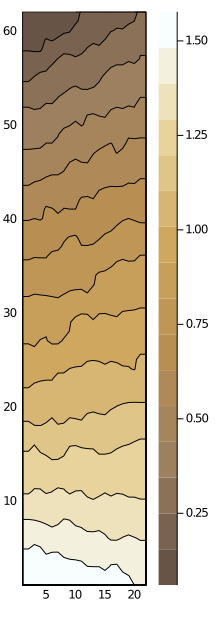

In [40]:
hydraulic_update = contour(z_soil, fill=true, size = (220, 620),  seriescolor=cgrad(ColorSchemes.coffee.colors))


Next we move on to the aeolian model. We have three parameters for transport-distance, all derived from the Kok & Renno (2009)’s COMSALT model:

- For each size class we have a *threshold* friction velocity, calculated as

$u_\star = \dfrac{(a\varphi^{\frac{\rho_a}{\rho_p}} +b)v}{\varphi}$

where $a = 13.31$, $\varphi$ our size class diameter, $\frac{\rho_a}{\rho_p} = 1.56$ (where $\rho_a$ is air density and $\rho_p$ is silica density, $b = 0.0038$, and $v$ the kinematic viscosity of air $1.81 × 10^{-5}$ kg(ms)$^{-1}$, after *Marticorena & Bergametti* (1995), *Marticorena &al.* (1997).

- Transport-distance parameters, which we assume as simple exponential *decay*. Since in this model we simply move from one parameter to the next, we can therefore 

- Horizontal mass flux parameters, which are fitted to an exponentially *rising* function


In [41]:
rho_a = 0.00234
rho_p = 2.65
g = 981*100
b = 0.0038*100
a = 13.31*100
v = v*100
x = 1.56
diameter_cm = diameter_meters/100 

u_1_1 = (a*diameter_cm[1])

# u_1_top =  (((rho_p * g * diameter_cm[1])/(rho_a))^0.5*(1+((0.006)/(rho_p * g * diameter_cm[1]^2.5))^0.5)))

u_1_top =  (0.129*(((rho_p * g * diameter_cm[1])/(rho_a))^0.5*(1+((0.006)/(rho_p * g * diameter_cm[1]^2.5))^0.5)))
u_1_bottom = (1.928 * (a*diameter_cm[1]^x + b)^0.092)^0.5

u_2_top = (0.129*(((rho_p * g * diameter_cm[2])/(rho_a))^0.5*(1+((0.006)/(rho_p * g * diameter_cm[2]^2.5))^0.5)))
u_2_bottom = (1.928 * (a*diameter_cm[2]^x + b)^0.092)^0.5

u_3_top = (0.129*(((rho_p * g * diameter_cm[3])/((rho_a))^0.5)*(1+((0.006)/(rho_p * g * diameter_cm[3]^2.5))^0.5)))
u_3_bottom = (1.928 * (a*diameter_cm[3]^x + b)^0.092)^0.5

u_4_top = (0.129*(((rho_p * g * diameter_cm[4])/((rho_a))^0.5)*(1+((0.006)/(rho_p * g * diameter_cm[4]^2.5))^0.5)))
u_4_bottom = (1.928 * (a*diameter_cm[4]^x + b)^0.092)^0.5


u_1 = (u_1_top/u_1_bottom)*0.0000625
u_2 = (u_2_top/u_2_bottom)*0.00014365
u_3 = (u_3_top/u_3_bottom)*0.000375
u_4 = (u_4_top/u_4_bottom)*0.00125


ustar_thresh = [0.4374, 0.5865, 0.6765, 1.675]

print(u_1)
print(u_2)
print(u_3)
print(u_4)

0.43737511476049720.53864464166518860.67652832526206811.6752968624583333

In addition, we can translate (roughly, unreliably given) mean wind speed $U$ to the friction velocity for the model via the following:

$ u_\star = \dfrac{Uk}{\log{\frac{z}{z_0}}}$

provided we know the height $z$ was measured and the $z_0$ roughness height (again, as with the hydraulic model lots of parameterizations but that’s necessary here). For demonstrative purposes we’ll just use $u_\star$ = 1.75.

We do this calculation out of the erosion-deposition look—if $u_\star > u_{\star_{thr}}$ we continue to the loop, otherwise no.

For the most part, with one exception, everything here decreases incrementally. The amount of mass—or rather unit per area volume (using the standard density of quartz), since we’re concerned with the thickness of removed sediment. We obtain the following exponential relationships to $u_\star$ for each of the sediment results, with `aeol_A`, `aeol_B`, and `aeol_C` being $Ae^{-Bx}+C$ for each size class.



In [42]:
depth_A = [0.3284,0.5564, 0.5256, 1.030]
depth_B = [-0.5579, -0.4384, -0.438]
depth_C = [-0.4135, -0.707, -1.453]

3-element Array{Float64,1}:
 -0.4135
 -0.707
 -1.453

Translating this mass to transport distance is more difficult. First, we need to understand how transport distance varies for each size class. For $\varphi = 1,2$ the data fits exponentially, though $\phi = 2$ is a very shallow exponent, for $\varphi = 3.0$ we have a linear fit, and given high variability for $\varphi = 4$ we just have simply use a constant. 

These values only give us the parameterization for median transport distances, though, not for mass. In order to arrive at an actual distance at (for north-to-sound wind ) `j = 1` we need an initial median transport distance in integers, derived from $f(d) = 1$. We double this to determine how far we iterate in the windward direction `jpos`. Since each additional cell gives an $f(d_{jpos})$ with correspondingly lower values. Integrating these values gives us the total amount of mass moves over $d_j, d_{j_{pos_j}}$ by by taking $d_{j_{pos}}$ over $\int_j^{j_{pos}}{f{d_j}}$. For $D_{\varphi = 1} = 0.0000625$, $u_\star = 1.75$ we get (with the sum for this case already calculated), as a percentage of soil removed

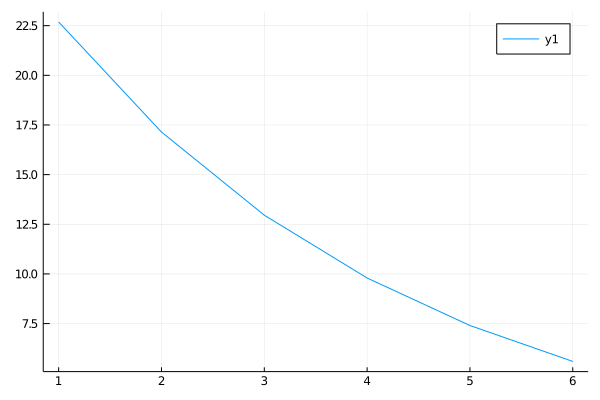

In [43]:
x = 1:6
y = ([(1/.28 * exp(-.28*1))/11.899, (1/.28 * exp(-.28*2))/11.899, (1/.28 * exp(-.28*3))/11.899, (1/.28 * exp(-.28*4))/11.899, (1/.28 * exp(-.28*5))/11.899, (1/.28 * exp(-.28*6))/11.899])

plot(x,y * 100)

So our actual parameters are:

where $h$ is total soil height. Additionally, for $D_{\varphi = 1} = 0.0000625$ we ultimately had the amount of 10% less soil deposited relative than removed to take suspension into account.

The exception to this is where aspect opposed the wind direction (in our example `aspect = 2`). If `aspect[i,jpos] = 2` all sediment to transported $f(d_{j_{pos}})/\sum_{j_{pos}-j}^{j_{pos}}{f(d)}$ is deposited at `jpos+1`, with the rest of the loop depositing zero, simulating the formation of small ripples and micro (nano?)-dunes after various papers by *Werner*, *Momiji*, and *Bass*, though I’m not quite sure how relevant they are at this time scale, iterating over one vector for slump to another. Additionally, these use a Moore rather than von Neumann neighborhood, so such a code looks something like this in Julia

~~~


Moore[1] = imtest_long_calc[i]
for m in 2:8
    Moore[m] = imtest_calc_long[i+n,j+n]
    largest_full = findmax(Moore)
    largest = largest_full[1]
    position_full = largest_full[2]
    position = position_full[2]
    if imtest_calc_long[i,j] >  slump_ratio * largest
        if position == x
            slump = imtest_calc_long[i,j]*1/slump_ratio
            imtest_calc_long[i,j] = imtest_calc_long[i,j] - slump
            imtest_calc_long[i+x,j+x] = imtest_calc_long[i+x,j+x] + slump
         end
     end
end


~~~

The largest/position parts are separating out values and coordinates from the `findmax` result, and the position `x` would be repeated for each of the eight directions.

In [44]:
d_det_A = fill(0,(1,2))
d_det_B = fill(0,(1,2))
d_det_C = fill(0,(1,2))

d_det_M = 0
d_det_D = 0

d_Const = 0


for p in 1:4
    if p == 1 || p == 2
            d_det_A = [0.0258, 0.1455]
            d_det_B = [0.5846, 0.2557]
            d_det_C = [0.0409, 0.0069]
            
#             d_Calc = d_det_A
            ## and the rest of the model goes here
            
        elseif p == 3
            d_det_M = 0.1144
            d_det_D = 0.3153
            
            ## and the rest of the model goes here
            
        else p == 4
            d_det_Const = 1.604
        
            ## and the rest of the model goes here
        
    end
    
end

(`long_update` was used because of edge between the initial and long ones models conditions earlier but isn’t necessary anymore. It’s in here just in case)

In [45]:
function long_update!(z,nc,nr,nc1,nr1,aspect,slope)


    for i in 2:nc, j in 2:nr
        if z[i,j] - z[i+1,j] < 0
            aspect[i,j] = 1
        elseif z[i,j] - z[i,j+1] < 0
            aspect[i,j] = 2
        elseif z[i,j] - z[i-1,j] < 0
            aspect[i,j] = 3
        elseif z[i,j] - z[i, j-1] < 0
            aspect[i,j] = 4
        end
    end

    # print(aspect)

    zmin = z .* aspect
    # #println(zmin)
    slope = [zmin[i+1,j] .- zmin[i,j] for i in 1:nc, j in 1:nr1]
    temp = fill(0, (1,nr1))

    # #Compensating for edge effects by setting them equal to interior
    slope[1,:] .= slope[2,:]
    slope = [slope;temp]
    slope[nc,:] .= slope[nc,:]
    slope[:,1] .= slope[:,2]
    slope[:,nr1] .= slope[:,nr]

    aspect[1,:] .= aspect[2,:]
    aspect[nc1,:] .= aspect[nc,:]
    aspect[:,1] .= aspect[:,2]
    aspect[:,nr1] .= aspect[:,nr]
    
    return z
    return aspect
    return slope
    
end

long_update! (generic function with 1 method)

First I add in a 

Here we calculate parameterizations are made for the aeolian model.

1. Mass removed from each gridcell
2. The length of gridcells that mass is transported. Since some degree of mass is transported across the entire landscape, we take two times the mean of the exponential decline in mass as our exponential curve of mass transported.
3. Binning the mass to exponentially decline over $n$ steps, with one-tenth of deposition removed for $\varphi = 1$ to take into account suspension. 

Only after these can we move on to the main loop.

In [46]:
### Making sure we can go back to our initial imtest for 
### testing the aeolian dep. model w/out re-running hydraulic
imtest_after_rain = imtest
# imtest = imtest_after_rain

62×22 Array{Float64,2}:
 0.015      0.015      0.015      …  0.015      0.015      0.015
 0.015      0.015      0.015         0.015      0.015      0.015
 0.015      0.015      0.015         0.0149999  0.015      0.015
 0.0149999  0.0149999  0.0149999     0.015      0.015      0.015
 0.015      0.015      0.0149999     0.0149999  0.015      0.015
 0.015      0.015      0.0149999  …  0.015      0.0149999  0.0149999
 0.0149999  0.0149999  0.015         0.0149999  0.015      0.015
 0.015      0.015      0.0149999     0.0149999  0.015      0.015
 0.0149999  0.0149999  0.015         0.015      0.015      0.015
 0.015      0.015      0.0149999     0.015      0.015      0.015
 0.015      0.015      0.015      …  0.015      0.015      0.015
 0.015      0.015      0.015         0.015      0.015      0.015
 0.0149999  0.0149999  0.0149999     0.015      0.015      0.015
 ⋮                                ⋱             ⋮          
 0.0149999  0.0149999  0.0149999  …  0.015      0.015      0.015
 0

In [47]:
imtest = imtest_after_rain
phi = 1
ustar = 1.75
# ustar_temp = fill(ustar,(phi,nc1,nr1))
# ustar_temp = fill(0.,(ustar,(phi,nc1,nr1)))
dist_param_ustar= fill(0.,(phi,1))
# aeolian_depos = fill(0.,(nc1,nr1))
remove = fill(0.,(phi,1))

###Adjusting for squared units
for p in 1:phi
    remove[p] = (depth_A[p] * exp(depth_B[p] + ustar) + depth_C[p])/1000000
end


###Adjusting for units, including dimensionally—
###have to take cell area into account too, so going from cm^2 to m^2


for p in 1:phi
        if p == 1 || p == 2
        dist_param_ustar[p] =  d_det_A[p] * exp(d_det_B[p] + ustar) + d_det_C[p]
        elseif p == 3
        dist_param_ustar[p] = d_det_M*ustar + d_det_D
        else p ==4
        dist_param_ustar[p] = d_det_Const
    end
end


# print(dist_param_ustar)
transp_length_mean = fill(0.,(phi,1))
for p in 1:phi
    transp_length_mean[p] = 1/dist_param_ustar[p] * exp(-dist_param_ustar[p])
end



length_steps = fill(0,(phi,1))


for p in 1:phi
    length_steps[p] = 2*trunc(Int64,transp_length_mean[p])
end



transp_frac = fill(0.,(phi,length_steps[phi],1))

mass_sum = fill(0.,(phi,length_steps[phi],1))

for p in 1:phi
#     print(p)
    for s in 1:length_steps[p]
        step_sum = 1/dist_param_ustar[p] * exp(-dist_param_ustar[p]*s)
        mass_sum[p] = mass_sum[p] + step_sum
    end
end

transp_frac = fill(0.,(phi,length_steps[phi],1))
for p in 1:phi
    for s in 1:length_steps[p]
#         print(s)
        transp_frac[p,s] = (1/dist_param_ustar[p] * exp(-dist_param_ustar[p]*s))/mass_sum[p]
    end
end

# print(mass_sum)

transp_depos = fill(0.,(phi,length_steps[phi],1))


for p in 1:phi
    for s in 1:length_steps[p]
        if phi == 1
            transp_depos[p,s] = remove[p] * transp_frac[p,s] * 0.9
        else
            transp_depos[p,s] = remove[p] * transp_frac[p,s]
        end
    end
end





overflowNS = fill(0.,(length_steps[phi]+1,nr1))

overflowEW = fill(0.,(length_steps[phi]+1),nc1)

# for p in 1:phi
#     incoming[p] = remove[p]
# end



5×62 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

When soil height in one cell is greater than that in an adjacent cell in the direction of wind travel, we implement a “slump” function after papers by *Werner*, *Momiji*, and *Baas*, where adjacent cells larger than twice their neighbors redistribute height. Here the repose parameter `slump_ratio` is set at $2$, i.e. slumping forward happens when one cell is double the height of its preceding cell.I am not sure just how applicable these are to microtopography, though. 

Early tests, though, using simple whole numbers for sediment moved across the landscape without any use of , eventually exhibited regular ripples with small variability based on slope and aspect (with the edge condition corresponding to the westward face [aspect = $3$] part of the landscape), here flipped since it was printed reversed in error. Each ridge, while regularly spaced based on ``length_steps`` and `transp-depos` values, increases over the northward dimension as more sediment is redistributed.

![](landtest_ripples.png)

While there is a degree of leeward slump (`i+` in the above case) so as to prevent any cells from getting too high, including a perpendicular slump (`j±`in this case) results in the presence of very thick (~1m) periodic patterns, which mainly arrive via horizontal slumping rather than periodic deposition-removal as above, which persist until the model hits sediment limitation. I considered this a model problem, or cause to have a separate `slump_ratio` values for windward or perpendicular cases. In contrast, *without* horizontal sluimping we have the development of corridors of low soil height determined by underlying topography and small random variations, which seems more correct to me. Getting morphologies like barchans (which I don’t think really exist on this scale) is often facilitated looking at cells that share a corner as well as a side.

For multiple wind directions in one timestep we use a `step_direction`. Depending on direction different wind directions lead to different models needs for sub-timesteps, so in the case of NbW, we have four sub-timestep groups to ensure consistency. Twelve sub-timesteps per timestep are always performed since this is the least common multiple of each case. This results in two northwards and one westward. I’m doing this in a “dumb” manual way here as opposed to an actual loop. Each aspect is stored (e.g. eight sub-timesteps for N, resulting in a imtest2_2, four for W, imtest2_1) in an `imtest2_(aspect)`, rotated back the original state and averaged. Two models are performed here: one simply facing north, and another NNW. So for instance for N:

~~~
If days_array[t,4] == 1
aeol_steps_2 = 12
Calculate u*
for p in 1:phi
if u* >= u*thr
for a in 1:aeol_steps_2
    for i in 1:aeol_steps_2 
        imtest_calc_long = imtest2_long
        aspect_calc = aspect_calc
        function(aeolian_transport)
    end
    function(process_imtest_calc)
    imtest = imtest_calc_2
    end
end

~~~

and for NMW:

~~~
If days_array[t,4] == 30
aeol_steps_2 = 8
aeol_steps_1 = 4
Big aeolian loop
Calculate u*
for p in 1:phi
if u* >= u*thr
for a in 1:aeol_steps
     for i in 1:aeol_steps_2 
        imtest_calc =  rot180(imtest, 1)
        imtest_calc_before =  imtest2
        imtest_calc_long = vcat(imtest2, overflowNS)
        aspect_calc = rot180(aspect, 1)
     end
     function(process_imtest_calc)
     imtest_calc_2
for a in aeol_steps_1
    if aeol_dir == 1
        imtest_calc =  rotr90(imtest, 1)
        imtest_calc_before =  imtest2
        imtest_calc_long = vcat(imtest2, overflowEW)
        aspect_calc = rot180(aspect, 1)
     end
     function(process_imtest_calc)
     imtest_calc_1
    end
     imtest = 0.5*(imtest_calc_1 + imtest_calc_2)

end

~~~

I average rather than doing eight timesteps N + four timesteps E in order—this allows both to start at the same initial `imtest` rather than worry about the order of timesteps in different directions, which in some of my early spring tests were just wrong (appearing more like crosses than diagonal corridors).

The easiest way to deal with mass transported *out* of the model is to concatenate a zeros overflow array. The direction of iteration (uphill/N or downhill/S) is determined here as well. Given the very small masses and timesteps involved (and this can go for the hydraulic model as well) the complexity of recalculating slope and aspect with every update can be avoided. Now, starting with an even wind forcing across the landscape—presently only implemented for uphill transport contra deposition (“S” here, or aspect = $2$) and downhill (“N” here, or aspect = $4$—note that since there are no cells with aspect = $4$ in our DEM there are no changes) using an `ipos = i ± 1` equivalent to what was used in the flow distribution model. Since we rotate by the array here, we are always using `i`. 


Cases based on direction: North (1) after 12 sub-timesteps and E (9) after 4 timesteps, and NNE (3) after 12 timesteps, no sediment incomingment.  One can see sediment removal on the endge where wind forcing starts and accumulation where the wind forcing ends (very high sediment accumulation is in the overflow cells). Within the landscape the slumps on the leeward edges of small areas of windward accumulation (largely related to areas of soil height change in the hydraulic model, e.g. on the westward, aspect = $3$ edge) are also visible. Micro-streets are in the direction of wind, and while the NNE model is somewhat noisier they can be seen there as well.

![](aeol_N_12.png) ![](aeol_E.png) ![](aeol_NNE.png) 

I have provided an `incoming` parameter for incoming sediment in the general parameter-setting cell, but I have left it at zero. It works as one would expect, but doesn’t give as good a picture of the evolution of the landscape over time under aeolian forcing—it tends to keep the landscape in a more-or-less steady state with only minimal changes over time. Here `incoming[p] = remove[p]`. Over twelve timesteps there are orders of magnitude more 

![](incoming_test.png)

In [24]:


        

aeol_dir = 1
## Upslope wind (“North”)  Βορεασ
if aeol_dir == 2 
    imtest_calc =  rotr90(imtest, 2)
    imtest_calc_before =  imtest_calc
    imtest_calc_long = vcat(imtest_calc, overflowNS)
    aspect_calc = rotr90(aspect, 2)
end



# ### Downslope wind (“South”)  Νοτοσ
if aeol_dir == 4 
    imtest_calc =  (imtest)
    imtest_calc_long = vcat(imtest_calc, overflowNS)
    aspect_calc = aspect
end

# # # # ### “East” wind Ευροσ
if aeol_dir == 1
    imtest_calc =  rotr90(imtest, 1)
    imtest_calc_before =  imtest
    imtest_calc_long = vcat(imtest_calc, overflowEW)
    aspect_calc = rotr90(aspect, 1)
end

# # # ### “West” wind Ζεφυροσ
if aeol_dir == 3
    imtest_calc =  rotr90(imtest, 3)
    imtest_calc_before =  imtest_calc
    imtest_calc_long = rotr90(imtest_calc, overflowEW)
    aspect_calc = aspect
end

    

    
    

# #Calculate u*
# #in a big, total_model loop with hydraulic transport
# #for b in days_array[t,3]
# #calculate u_star
# #if u_star > u_star_thr
# #function(median aeolian loop)


# ### Example for N

# ### Example for N
# # If days_array[t,4] == 1
# # aeol_steps_2 = 12
# # Big aeolian loop
# # Calculate u*
# # for p in 1:phi
# # if u* >= u*thr
# # for a in 1:aeol_steps_2
# #     for i in 1:aeol_steps_2 
# #         imtest_calc_long = imtest_calc_long
# #         aspect_calc = aspect_calc
# #         function(aeolian_transport)
# #     end
# #     function(process_imtest_calc)
# #     imtest = imtest_calc_2
# #     end
# # end


# ### Example for NNW
# # If days_array[t,4] == 30
# # aeol_steps_2 = 8
# # aeol_steps_1 = 4
# # Big aeolian loop
# # Calculate u*
# # for p in 1:phi
# # if u* >= u*thr
# # in a big loop with hydraulic transport
# # for a in 1:aeol_steps_2
# #     for i in 1:aeol_steps_2 
# #         imtest_calc_long = imtest_calc_long
# #         aspect_calc = aspect_calc
# #         function(aeolian_transport)
# #     end
# #     function(process_imtest_calc)
# #     imtest_calc_2
# # for a in aeol_steps_1
# #     for i in 1:aeol_steps_2 
# #         imtest_calc_long = imtest_calc_long
# #         aspect_calc = aspect_calc
# #         function(aeolian_transport)
# #     end
# #     function(process_imtest_calc)
# #     imtest_calc_1
# #     imtes
#t = 0.5*(imtest_calc_1 + imtest_calc_2)
# #    END
# # end


In [25]:
if aeol_dir == 2

for p in 1:phi #included outside this loop in final model
    for s in 1:8
    for i in 1:nc1,j in 1:nr1
#             i 
#             jpos = j
            if imtest_calc_long[i,j] > abs(remove[p])
            if aspect_calc[i,j] == 2
                        imtest_calc_long[i,j] = imtest_calc_long[i,j] - remove[p]
                        for l in 1:length_steps[p]

                            imtest_calc_long[i+l,j] = imtest_calc_long[i+l,j] + transp_depos[p,l]
                            ##STANDARD FORWARD SLUMP
                            if imtest_calc_long[i+l,j] >  slump_ratio * imtest_calc_long[i+l-1,j]
                                slump =  imtest_calc_long[i + l-1,j]*1/slump_ratio
                                imtest_calc_long[i + l-1,j] = imtest_calc_long[i + l-1,j] - slump  - transp_depos[p,l]# - transp_depos[p,l]
                                imtest_calc_long[i + l,j] = imtest_calc_long[i + l,j] + slump +  transp_depos[p,l]
                                ###VON NEUMANN SLUMP
#                                     for jpos in 2:nr
#                                     if imtest_calc_long[i,jpos] >  slump_ratio * imtest_calc_long[ipos,jpos+1]
#                                         slumpj =  imtest_calc_long[i,jpos]*1/slump_ratio
#                                         imtest_calc_long[i,jpos] = imtest_calc_long[ipos,jpos] - slumpj
#                                         imtest_calc_long[i,jpos+1] = imtest_calc_long[i,jpos+1] + slumpj
#                                     if imtest_calc_long[i,jpos] >  slump_ratio * imtest_calc_long[ipos,jpos-1]
#                                         slumpj =  imtest_calc_long[i,jpos]*1/slump_ratio
#                                         imtest_calc_long[i,jpos] = imtest_calc_long[ipos,jpos] - slumpj
#                                         imtest_calc_long[i,jpos-1] = imtest_calc_long[i,jpos-1] + slumpj
                                ###BARCHAN-MACROGEOMOslump_ratioHOLOGY SLUMP
#                                         EVERY i±1, j±1 COMBINATION
#                         end
                        end
                        end
                
                end
                end
             imtest_calc_long[i,j] = imtest_calc_long[i,j] + incoming[p]

#                     end
                end

    end

    end
end
                    


if aeol_dir == 1
###For 1,3 (E,W)

for p in 1:phi #included outside this loop in final model
    for t in 1:4
    for i in 1:nr1,j in 1:nc1
            ipos = i 
            jpos = j
            if imtest_calc_long[ipos,j] > abs(remove[p])
            if aspect_calc[ipos,j] == 2
                    imtest_calc_long[ipos,j] = imtest_calc_long[ipos,j] - remove[p]
                    if imtest_calc_long[ipos,j] > remove[p]
                        for l in 1:length_steps[p]
                            imtest_calc_long[ipos+l,j] = imtest_calc_long[ipos+l,j] + transp_depos[p,l]
                            ###STANDARD FORWARD SLUMP
                            if imtest_calc_long[ipos+l,j] >  slump_ratio * imtest_calc_long[ipos+l-1,j]
                                slump =  imtest_calc_long[ipos + l-1,j]*1/slump_ratio
                                imtest_calc_long[ipos + l-1,j] = imtest_calc_long[ipos + l-1,j] - slump + transp_depos[p,l]# - transp_depos[p,l]
                                imtest_calc_long[ipos + l,j] = imtest_calc_long[ipos + l,j] + slump - transp_depos[p,l]
                                ###VON NEUMANN SLUMP
#                                     for jpos in 2:nr
#                                     if imtest_calc_long[i,jpos] >  slump_ratio * imtest_calc_long[ipos,jpos+1]
#                                         slumpj =  imtest_calc_long[i,jpos]*1/slump_ratio
#                                         imtest_calc_long[i,jpos] = imtest_calc_long[ipos,jpos] - slumpj
#                                         imtest_calc_long[i,jpos+1] = imtest_calc_long[i,jpos+1] + slumpj
#                                     if imtest_calc_long[i,jpos] >  slump_ratio * imtest_calc_long[ipos,jpos-1]
#                                         slumpj =  imtest_calc_long[i,jpos]*1/slump_ratio
#                                         imtest_calc_long[i,jpos] = imtest_calc_long[ipos,jpos] - slumpj
#                                         imtest_calc_long[i,jpos-1] = imtest_calc_long[i,jpos-1] + slumpj
                                ###BARCHAN-MACROGEOMOslump_ratioHOLOGY SLUMP
#                                         EVERY i±1, j±1 COMBINATION
# #                         end
                    end
                end
                
                            end
                        end
                    end
            imtest_calc_long[ipos,j] = imtest_calc_long[ipos,j] #+ incoming[p]
                end

    end

    end
    end


# # print(sum(imtest_calc_long)
# # lee_check = contour(imtest_calc_long-imtest2_init_long, fill=true, size = (220, 620),  seriescolor=cgrad(ColorSchemes.coffee.colors))

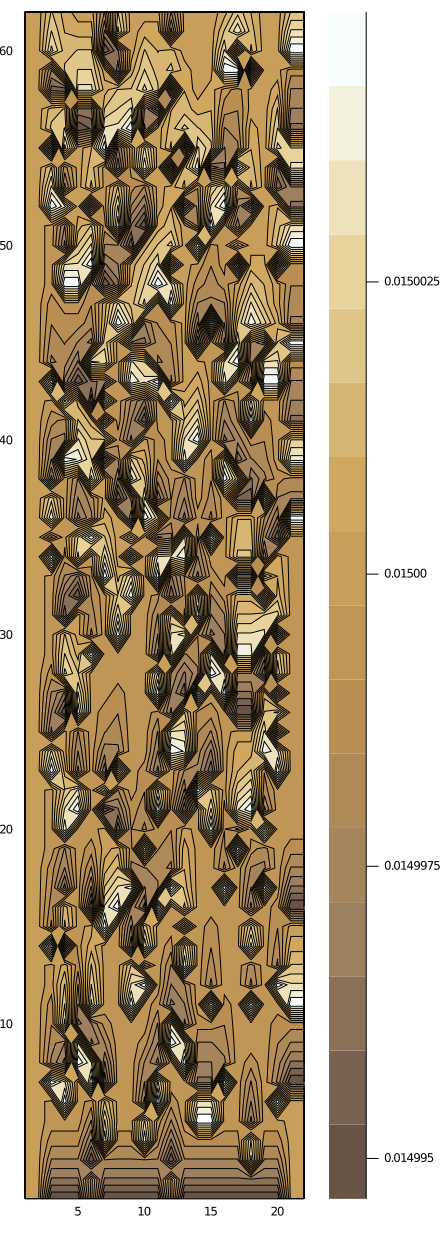

In [23]:
# #Unidirectional case N
imtest_calc_new = (imtest_calc_long[1:nc1,:])
imtest_calc_new_2 = imtest_calc_new
# imtest_calc_new = imtest_calc_new_2
# imtest = rotr90(imtest_calc_new_2,2)
# z_soil = z_soil+imtest
# imstore = imtest_calc_new_2
#,clim=(0.0149,0.015)
# land_update!(nc,nr,nc1,nr1,z,aspect,slope)
aeol_check = contour(imtest_calc_new, fill=true, size = (220*2, 620*2),  seriescolor=cgrad(ColorSchemes.coffee.colors))
# savefig(aeol_check, "ts3.png")

# imtest = imtest_calc_new_2


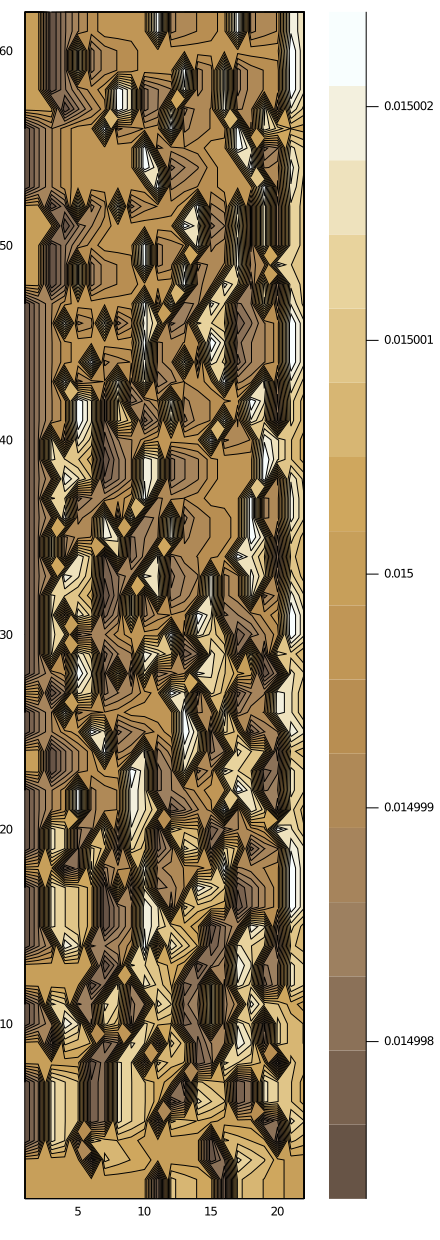

In [26]:
# # #Unidirectional case W
imtest_calc_new = rotr90(imtest_calc_long[1:nr1,:],3)
imtest_calc_new_1 = imtest_calc_new
aeol_check = contour(imtest_calc_new_1, fill=true, size = (220*2, 620*2),  seriescolor=cgrad(ColorSchemes.coffee.colors))
# savefig(aeol_check, "final/aeol_W")

# imtest = imtest_calc_new_2



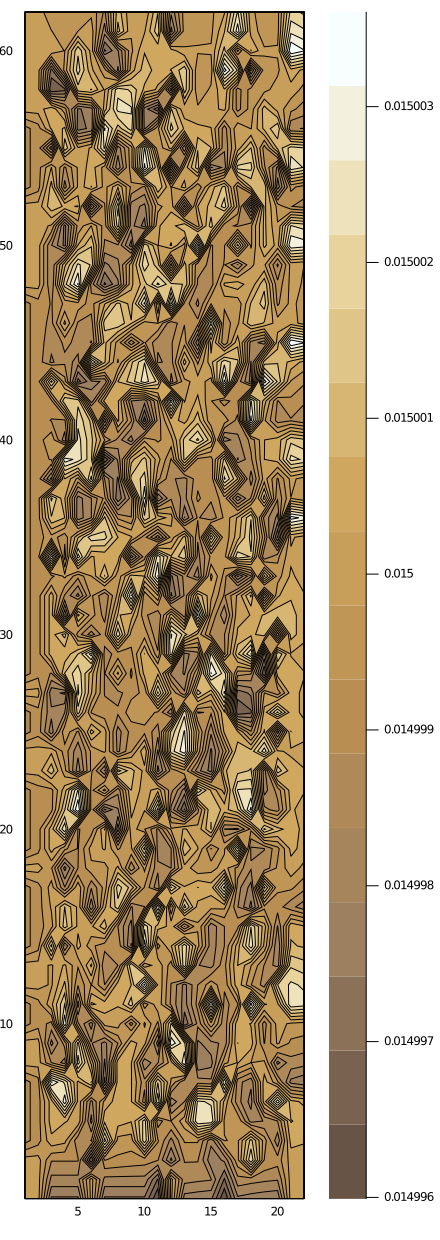

In [29]:
#Bidirectional case NNW
imtest = 0.5*(imtest_calc_new_1 + imtest_calc_new_2)
z_soil = z_soil+imtest
aeol_check = contour(imtest, fill=true, size = (220*2, 620*2),  seriescolor=cgrad(ColorSchemes.coffee.colors))



Over shorter periods the landforms are mainly blown out from wind, with sub-millimeter changes again over short terms—keeping constant little change. 


While over relatively short (tens-low thousands of timestep, first figures for $t = 1000$ northwards) timescales sediment movements remain in the range of submillimeter and millimeter ranges, as we head into the order of ~10k (second figure) timesteps eventually leading to large streaks of low or scoured soil with areas of deposition between them based on aspect and small initial differences in soil heights. Over short terms soil is transferred in the direction of deposition and eventually out via the (and, in the case of $\varphi = 1$, suspension), but with the emergence of quasi-streets results in greater deposition (in this case) downslope as more sediment is transferred out of the model, with small areas of sustained increasing deposition, resulting in ~100 mm differences between scoured and deposited areas. This, of course, is unrealistic—this assumes zero sediment input. However, in all cases the difference in soil height over most of the landscape is .

![](aeol_N_1000.png)
![](aeol_N_10000.png)
 
The key questions for the reality of the model are those of temporal scaling. Although entrainment of particles is a gusty process, we can assume that, over long timespans, these even out to uniform forcing across the landscape. How long a `t` corresponds to the above process, though, still needs to be parameterized. This way the above timeseries can be turned into simple entries in the two columns in the above timeseries setting-up for wind speed and direction. 

Early tests, using simple whole numbers for sediment moved across the landscape, eventually exhibited regular ripples with small variability based on slope and aspect (and a poorly-handled edge condition). Since this model moves smaller amounts of sediment, these 

The main task, for running in Julia, is to make each of the above modules into callable functions, with inputs being the initial forcing (wind speed `ws` converted to $u_\star$ in the aeolian case, rainfall intensity `rval` in the hydraulic) and the rest being the landscapes needed, namely `imtest,nc,nr,nc1,nr1,z,aspect,slope`.

```
ws = wind strength
wd = wind direction

Set initial landscapes, parameterizations

series = weather data

interval = length(series)

for t in 1:interval

    if series[t,1] > 0
### Checking for soil moisture in case we explicitly use it for this
#    if any(x->x > 0.15, theta) = true
        imtest = imtest
    else
        ws = series[1,t]
        wd = series [2,t]
        for p in 1:phi:
            if u_star > ustar_thresh[p]
            aeol_transport!(ws,landscapes)
    
    if series[t,1] == 2
    rval = series[1,t]
    hydraulic_transport!(rval,landscapes)
    
end
    
```

Given that there are sometimes (unjustified! okay maybe not *totally* but we in Julia twitter make it work) complaints about Julia’s stability, and for the sake of backwards-compatibility, in Fortran it would look like this (although IO problems and compatibility problems would still need to be solve, i.e. replacing XML stuff with the simpler inputs from MAHLERAN 1.1.5 and updating for GCC9, or alternatively going down to GCC7). We can simply add aeolian parameters to `mahleran_input_(version).dat` files and include the aeolian parameters discussed above in `read_parameters.for` (although use of .dat is not always possible—or at least not always easy—due to variable delimiters).

Reading landscape maps includes a pavement map; this is ignored here though one of *Gilette*’s papers offers potential insights into this.

Then for the primary loop we have to embed both the hydrological loop and the aeolian loop within one time series: although here we have the following structure of calling subroutines:

~~~

c    revised io switching to our simpler day_array, even as hydraulic
c    model still uses the simple 1 day = 1 hour &c.
c    REVISED IO

c Call landscape maps here, same since no unique ones for aeolian

c Now including aeolian stuff
use shared_data

c    Main loop
       num = 0
       
       
       
       do iter = 1, nit
       
        write (6, *) ' Starting iteration ', iter, int(rval*3600), int(wd), int(ws)
        
        
        if day_array(2).gt.0 then

          call set_rain
          
          call infilt

          call accumulate_flow

          call route_water

          call route_sediment
          
          c splash_transport &c. are called here
          
          call route_sediment
          
          call update_sediment_flow
         
          
          c call route_chemistry not used here, wait for Stewart &al. with aeolian
          
          c Since *small* changes help initialize aeolian microgeomrphology, rather than
          c we translate the above long_update! (itself based on an edited version of
          c dynamic_topog_attribute) to take into account very small changes in soil
          c height
            
          call update_microgeomorph
          
          
        else
           if theta_switch.eq.2 then
               if ( any( theta.ge.0.15) ) exit 
           else
                         
              call aeol_move
                                                                     
              call update_microgeomorph
                            
           end if
           
        end if
        enddo

~~~

`aeol_move` is a large subroutine that calls: including *all* the above steps. Key things to speed it up include:

- `aeol_dists`, setting up the transport-distances. Additionally, rather than concatenating an array, a large empty array of `imtest + 2 * length_steps, imtest + 2 * length_steps` is made and rather than filling aroun `nr2` &c. new `nr_center`, `nc_center` are where iteration begins, starting at `nr2 + length_steps` and `nr2 + length_steps`, so we don’t have to concatenate arrays each time. So rather than different dimensions of `imtest_calc_long` we have a single `imtest_calc_big`

- `aeol_route`, which, based on wind direction, as shown above with the minor changes needed to implement in Fortran—it is also very long, or could be split into different modules for different sums of temps in . `imtest` (which should be something like more legible and symmetrical to the hydraulic model something like `aeol_sed_temp`; additionally we do not have to worry about ending flows as in the concentrated flow subroutine and then). `aeol_route` would not be terribly large, only comparable to `splash_transport`—much as `splash_across` values are defined in first and then given for each aspect case, we define directions and then how they’re applied and averaged for each of the 32 compass directions.